In [19]:
import torch
from torch.utils.data import Dataset
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

## need a trick for zuko
install package once, with the following command
```!pip install --user zuko```
then reload swan following instructions here --> https://swan.docs.cern.ch/advanced/install_packages/

In [20]:
import zuko
from zuko.flows import Flow, UnconditionalDistribution, UnconditionalTransform
from zuko.flows.autoregressive import MaskedAutoregressiveTransform
from zuko.distributions import DiagNormal
from zuko.transforms import RotationTransform

In [21]:
class ChunkedNumpyDataset(Dataset):
    def __init__(self, input_paths, max_events=None, device=None):
        
        self.input_data = []
        
        for input_path in input_paths:
            if max_events:
                self.input_data.append(torch.from_numpy(np.load(input_path)[:max_events]).to(torch.float32))
            else:
                self.input_data.append(torch.from_numpy(np.load(input_path)).to(torch.float32))
        
        self.total_length = min(len(d) for d in self.input_data)
        assert all(len(d) == self.total_length for d in self.input_data), \
            "All input and target arrays must have the same length"
        
        if device:
            self.input_data = [data.pin_memory().to(device) for data in self.input_data]
    
    def __len__(self):
        return self.total_length 
    
    def __getitem__(self, idx):
        
        inputs = [data[idx] for data in self.input_data]
        return inputs
    
def get_obj_type_tensor(max_njets):
    o = torch.zeros((max_njets+2+1+1, 1), dtype=torch.float32) # 2 leptons, 1 MET, 1 jj
    o[-3:-1,0] = 1.
    o[-1,0] = -1.
    return o

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [22]:
datafolder = "/eos/user/g/glavizza/nanoAOD/ntuples_polarized/training_datasets"

# Usage example
input_paths_training = [ f"{datafolder}/{f}_training.npy" for f in ["jet_data", "lep_data", "met_data","jj_data","jetlepmetjj_padding_mask",  "nu_data"]]
input_paths_validation = [ f"{datafolder}/{f}_validation.npy" for f in ["jet_data", "lep_data", "met_data","jj_data","jetlepmetjj_padding_mask", "nu_data"]]

dataset_train = ChunkedNumpyDataset(input_paths_training, max_events=600000) # device="cuda"
dataset_val  = ChunkedNumpyDataset(input_paths_validation, max_events=100000) # device="cuda"

# Create DataLoader
batch_size = 2048
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size*5, shuffle=True)


In [23]:
jets, lepton, met, jj, full_mask, nu = dataset_train[0:10000]

Text(0.5, 0, 'nu phi normalized')

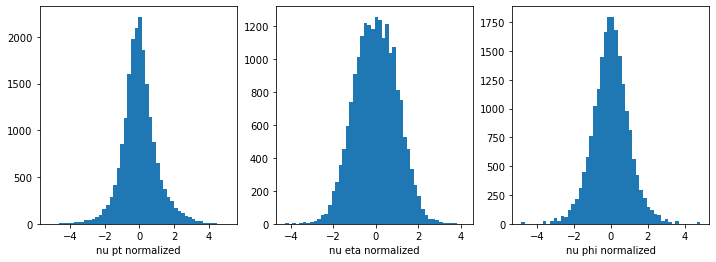

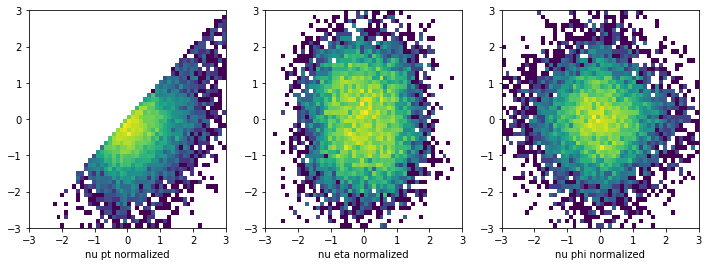

In [24]:
f, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].hist(nu.cpu().numpy()[:,:,0].flatten(), bins=50);
axs[0].set_xlabel("nu pt normalized")
axs[1].hist(nu.cpu().numpy()[:,:,1].flatten(), bins=50);
axs[1].set_xlabel("nu eta normalized")
axs[2].hist(nu.cpu().numpy()[:,:,2].flatten(), bins=50);
axs[2].set_xlabel("nu phi normalized")

f, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].hist2d(nu.cpu().numpy()[:,0,0].flatten(),
            nu.cpu().numpy()[:,1,0].flatten(), bins=50, range=((-3,3),(-3,3)), norm=LogNorm());
axs[0].set_xlabel("nu pt normalized")
axs[1].hist2d(nu.cpu().numpy()[:,0,1].flatten(),
            nu.cpu().numpy()[:,1,1].flatten(), bins=50,  range=((-3,3),(-3,3)),norm=LogNorm());
axs[1].set_xlabel("nu eta normalized")
axs[2].hist2d(nu.cpu().numpy()[:,0,2].flatten(),
            nu.cpu().numpy()[:,1,2].flatten(), bins=50,  range=((-3,3),(-3,3)), norm=LogNorm());
axs[2].set_xlabel("nu phi normalized")


# Transformer encoder for normalizing flow

In [25]:
from torch import nn
from torch.nn import TransformerEncoder,TransformerEncoderLayer


class WWEncoder(nn.Module):
    
    def __init__(self, d_model=128, nhead=8, 
                 num_encoder_layers=2, 
                 dim_feedforward=512,
                 output_dim=16,
                 output_net=[64,64],
                 jet_features = 4,
                 let_features = 3, 
                 met_features = 2,
                 jj_features = 2,
                 max_njets= 10,
                ):
        super().__init__()
        self.d_model = d_model
        
        self.transformer_enclayer = TransformerEncoderLayer(d_model, nhead, dim_feedforward,batch_first=True)
        self.transformer_encoder = TransformerEncoder(self.transformer_enclayer, num_layers=num_encoder_layers, enable_nested_tensor=True)

        self.embedding_jets = nn.Sequential(
            nn.Linear(jet_features, d_model-1), # -1 to account for the additional label added to the features
            nn.SELU()
        )
        self.embedding_lep = nn.Sequential(
            nn.Linear(let_features, d_model-1),
            nn.SELU()
        )
        self.embedding_met = nn.Sequential(
            nn.Linear(met_features, d_model-1),
            nn.SELU()
        )
        self.embedding_jj = nn.Sequential(
            nn.Linear(jj_features, d_model-1),
            nn.SELU()
        )

        # Building the accumulation net for the output of the encoder
        _layers = [nn.Linear(d_model, output_net[0]), nn.SELU()]
        for i in range(len(output_net)-1):
            _layers.append(nn.Linear(output_net[i], output_net[i+1]))
            _layers.append(nn.SELU())
            
        _layers.append(nn.Linear(output_net[-1], 1))
        _layers.append(nn.Sigmoid()) # to have a number between [0,1]
        self.output_network = nn.Sequential(*_layers)
        self.proj_out = nn.Linear(d_model, output_dim)

        self.register_buffer('obj_type', get_obj_type_tensor(max_njets))
        

    def forward(self, jets, leptons, met, jj, full_mask):
        batch_size = jets.size(0)
        emb_jets = self.embedding_jets(jets)
        emb_lep = self.embedding_lep(leptons)
        emb_met = self.embedding_met(met)
        emb_jj = self.embedding_jj(jj)
        
        print('batch_size', batch_size)
        labels = self.obj_type.expand(batch_size, *list(self.obj_type.shape))
        
        emb = torch.cat([emb_jets, emb_lep, emb_met, emb_jj], dim=1)
        print ('embedded objs',emb.shape)
        print ('embedded labels',labels.shape)
        emb = torch.cat([emb, labels], dim=-1)

        # expanding the mask for lepton and met
        # the src_key_padding_mask needs to have True where the tokens are padded. 
        # Our full mask has 1 where the tokens are preset
        pad_mask = full_mask == 0
        out_transf = self.transformer_encoder(src=emb, src_key_padding_mask=pad_mask)
        score = self.output_network(out_transf)
        #Now using the score to accumulate the output
        # we need to mask the transformer encoder token that are padded
        out = torch.sum((out_transf * score * full_mask.unsqueeze(2)), axis=1)
        # Final projection
        out = self.proj_out(out)
        return out

In [26]:
# Example usage
d_model = 64
output_dim = 16
nhead = 4
num_encoder_layers = 2

model = WWEncoder(d_model, nhead, num_encoder_layers,
                   output_dim = output_dim,
                   output_net=[16])
#model.to("cuda")
print(f"Model parameters: {count_parameters(model)}")


Model parameters: 252066


In [27]:
out = model(jets, lepton, met, jj, full_mask)
print(out)

batch_size 10000
embedded objs torch.Size([10000, 14, 63])
embedded labels torch.Size([10000, 14, 1])
tensor([[ 1.7193,  1.8170,  0.0148,  ...,  1.1161, -0.4491, -1.1567],
        [ 1.6306,  0.5351,  0.3924,  ...,  0.8133, -0.8567, -1.1278],
        [ 1.4171,  1.4392, -0.5984,  ...,  1.7661, -0.2416, -0.8886],
        ...,
        [ 1.9310,  0.3111,  0.8350,  ...,  1.5139, -1.2066, -1.0345],
        [ 1.2137,  0.3564, -0.3515,  ...,  1.3508, -0.7418, -1.8157],
        [-0.0156,  1.2241,  0.4074,  ...,  0.1705, -0.0840, -0.6131]],
       grad_fn=<AddmmBackward0>)


In [28]:
flow = Flow(
    transform=[
        MaskedAutoregressiveTransform(features=6, context=16, hidden_features=(64, 64), passes=2),
        UnconditionalTransform(RotationTransform, torch.randn(6, 6)),
        MaskedAutoregressiveTransform(features=6, context=16, hidden_features=(64, 64), passes=2),
    ],
    base=UnconditionalDistribution(
        DiagNormal,
        torch.zeros(6),
        torch.ones(6),
        buffer=True,
    ),
)
#flow.to("cuda")
flow

Flow(
  (transform): LazyComposedTransform(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicAffineTransform()
      (order): [0, 0, 0, 1, 1, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=22, out_features=64, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=64, out_features=12, bias=True)
      )
    )
    (1): UnconditionalTransform(RotationTransform())
    (2): MaskedAutoregressiveTransform(
      (base): MonotonicAffineTransform()
      (order): [0, 0, 0, 1, 1, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=22, out_features=64, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=64, out_features=12, bias=True)
      )
    )
  )
  (base): UnconditionalDistribution(DiagNormal(loc: torch.Size([6]), scale: torch.Size([6

In [29]:
out.shape

torch.Size([10000, 16])

In [30]:
torch.reshape(nu, [nu.shape[0], 6])

tensor([[ 0.0192, -0.2467,  0.7101, -0.4500, -0.5681,  0.3738],
        [-0.5778,  0.5406,  0.1465, -1.6882, -2.4508, -1.5484],
        [ 1.9297, -0.0126, -3.3000, -1.8624,  0.6908,  0.9469],
        ...,
        [ 0.4573, -1.2663,  1.3884,  0.2860, -0.0203, -1.1493],
        [-0.2722, -0.7991, -1.1027, -0.9586, -1.2108, -0.2163],
        [ 0.7729,  0.0742,  0.7101, -0.5624,  1.8778,  2.7942]])

In [31]:
log_prob = flow(out).log_prob(torch.reshape(nu, [nu.shape[0], 6]))

Text(0.5, 0, 'log(prob) of neutrinos')

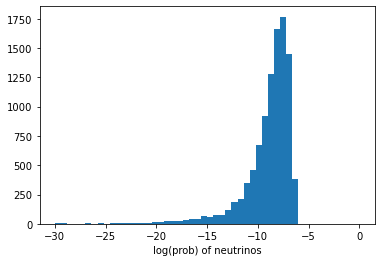

In [32]:
plt.hist(log_prob.cpu().detach().numpy(), bins=50, range=(-30, 0));
plt.xlabel("log(prob) of neutrinos")

# Full model

In [40]:
from torch import nn
from torch.nn import TransformerEncoder,TransformerEncoderLayer

class NeutrinosFlow(nn.Module):
    
    def __init__(self, 
                 flow_nlayers=4, 
                 flow_hidden_net=(64,64),
                 flow_coupling=True,
                 d_model=128, 
                 nhead=8, 
                 num_encoder_layers=2, 
                 dim_feedforward=512,
                 context_dim=16,
                 context_net=[64,64],
                 jet_features = 4,
                 let_features = 3, 
                 met_features = 2,
                 jj_features = 2,
                 max_njets= 10,
                ):
        super().__init__()

        self.encoder = WWEncoder(d_model=d_model,
                                 nhead=nhead, 
                                 num_encoder_layers=num_encoder_layers, 
                                 dim_feedforward=num_encoder_layers,
                                 output_dim=context_dim,
                                 output_net=context_net,
                                 jet_features = jet_features,
                                 let_features = let_features, 
                                 met_features = met_features,
                                 jj_features = jj_features,
                                 max_njets= max_njets)

        flow_transf_layers = []
        for i in range(flow_nlayers-1):
            flow_transf_layers.append(MaskedAutoregressiveTransform(features=6, 
                                                                    context=context_dim, 
                                                                    hidden_features=flow_hidden_net, 
                                                                    passes=2 if flow_coupling else None))
            # Let's add a rotation of the features
            flow_transf_layers.append(UnconditionalTransform(RotationTransform, torch.randn(6, 6)))
        # adding last transformation
        flow_transf_layers.append(MaskedAutoregressiveTransform(features=6, 
                                                                    context=context_dim, 
                                                                    hidden_features=flow_hidden_net, 
                                                                    passes=2 if flow_coupling else None))
  
        self.flow = Flow(
                transform=flow_transf_layers,
                base=UnconditionalDistribution(
                    DiagNormal,
                    torch.zeros(6),
                    torch.ones(6),
                    buffer=True,
                ),
            )

    def forward(self, jets, leptons, met, jj, full_mask):
        conditioning_vector = self.encoder(jets, leptons, met, jj, full_mask)
        # Our model returns a flow model with the correct conditioning
        return self.flow(conditioning_vector)

# Training

In [41]:
def train_flow(model, device, loader, val_loader,  optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        for batch_idx, (jets, lepton, met, jj, full_mask, nu) in enumerate(loader):
            optimizer.zero_grad()

            log_prob = model(jets,lepton,met,jj, full_mask).log_prob(torch.reshape(nu, [nu.shape[0], 6]))
            loss = - log_prob.mean()
            
            if batch_idx % 100 == 0:
                print(f"epoch {epoch}, step {batch_idx}, Loss: {loss.item():.4f}")
                
            loss.backward()
            
            optimizer.step()
            
    
        # Validation loss
        #model.eval()  #I'm having problems with model.eval
        val_loss = 0.  
       
        with torch.no_grad():
            for jets_val, lepton_val, met_val, jj_val ,full_mask_val, nu_val, in val_loader:
                flow_conditioned_val = model(jets_val,lepton_val, met_val, jj_val, full_mask_val)
                log_prob_val = flow_conditioned_val.log_prob(torch.reshape(nu_val, [nu_val.shape[0], 6]))
                val_loss = - log_prob_val.mean()
            
            print(f"epoch {epoch}, Validation Loss: {val_loss:.4f}")

           
        print(f"End of epoch {epoch}")
    return model

In [42]:
# Example usage
d_model = 64
nhead = 8
num_encoder_layers = 4
flow_nlayers= 2
flow_hidden_net=(64,64)
context_net=[32,32]
flow_coupling=False
learning_rate = 1e-3
num_epochs = 5


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeutrinosFlow(d_model = d_model,
                      nhead = nhead,
                      num_encoder_layers = num_encoder_layers,
                      flow_nlayers=flow_nlayers ,
                      flow_hidden_net=flow_hidden_net,
                      flow_coupling=flow_coupling,
                      context_net=context_net)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

print(f"Model parameters: {count_parameters(model)}")

Model parameters: 105394


In [43]:
jets, lepton, met, jj, full_mask, nu = dataset_train[0:1000]
log_prob = model(jets,lepton,met,jj, full_mask).log_prob(torch.reshape(nu, [nu.shape[0], 6]))
loss = - log_prob.mean()
print(loss)

batch_size 1000
embedded objs torch.Size([1000, 14, 63])
embedded labels torch.Size([1000, 14, 1])
tensor(9.1381, grad_fn=<NegBackward0>)


In [ ]:
trained_model = train_flow(model, device, dataloader_train, dataloader_val, optimizer, num_epochs)

batch_size 2048
embedded objs torch.Size([2048, 14, 63])
embedded labels torch.Size([2048, 14, 1])
epoch 0, step 0, Loss: 9.1416
batch_size 2048
embedded objs torch.Size([2048, 14, 63])
embedded labels torch.Size([2048, 14, 1])
batch_size 2048
embedded objs torch.Size([2048, 14, 63])
embedded labels torch.Size([2048, 14, 1])
batch_size 2048
embedded objs torch.Size([2048, 14, 63])
embedded labels torch.Size([2048, 14, 1])
batch_size 2048
embedded objs torch.Size([2048, 14, 63])
embedded labels torch.Size([2048, 14, 1])
batch_size 2048
embedded objs torch.Size([2048, 14, 63])
embedded labels torch.Size([2048, 14, 1])
batch_size 2048
embedded objs torch.Size([2048, 14, 63])
embedded labels torch.Size([2048, 14, 1])
batch_size 2048
embedded objs torch.Size([2048, 14, 63])
embedded labels torch.Size([2048, 14, 1])
batch_size 2048
embedded objs torch.Size([2048, 14, 63])
embedded labels torch.Size([2048, 14, 1])
batch_size 2048
embedded objs torch.Size([2048, 14, 63])
embedded labels torch.

batch_size 2048
embedded objs torch.Size([2048, 14, 63])
embedded labels torch.Size([2048, 14, 1])
batch_size 2048
embedded objs torch.Size([2048, 14, 63])
embedded labels torch.Size([2048, 14, 1])
batch_size 2048
embedded objs torch.Size([2048, 14, 63])
embedded labels torch.Size([2048, 14, 1])
batch_size 2048
embedded objs torch.Size([2048, 14, 63])
embedded labels torch.Size([2048, 14, 1])
batch_size 2048
embedded objs torch.Size([2048, 14, 63])
embedded labels torch.Size([2048, 14, 1])
batch_size 2048
embedded objs torch.Size([2048, 14, 63])
embedded labels torch.Size([2048, 14, 1])
batch_size 2048
embedded objs torch.Size([2048, 14, 63])
embedded labels torch.Size([2048, 14, 1])
batch_size 2048
embedded objs torch.Size([2048, 14, 63])
embedded labels torch.Size([2048, 14, 1])
batch_size 2048
embedded objs torch.Size([2048, 14, 63])
embedded labels torch.Size([2048, 14, 1])
batch_size 2048
embedded objs torch.Size([2048, 14, 63])
embedded labels torch.Size([2048, 14, 1])
batch_size

In [ ]:
torch.save(model.state_dict(), "models/models_nuflow_coupling_v1.pt")

In [ ]:
def plot_samples(nu_sampl, nu_true):
    f1 , axs = plt.subplots(2, 3, figsize=(12, 8))
    for i in range(2):
        for j in range(3):
            f = plt
            axs[i][j].hist2d(nu_sampl[:,i, j], nu_true[:,i, j],
              bins=60, 
            norm=LogNorm())
            if j == 0:
                axs[i][j].set_xlabel("Target pt")
                axs[i][j].set_ylabel("Regressed pt")
            elif j == 1:
                axs[i][j].set_xlabel("Target eta")
                axs[i][j].set_ylabel("Regressed eta")
            elif j == 2:
                axs[i][j].set_xlabel("Target phi")
                axs[i][j].set_ylabel("Regressed phi")
            elif j == 3:
                axs[i][j].set_xlabel("Target mass")
                axs[i][j].set_ylabel("Regressed mass")

In [ ]:
Nsamples = 30000
dataset_val  = dataloader.ChunkedNumpyDataset(input_paths_validation, max_events=Nsamples, device="cuda")

samples_all = torch.zeros(1, Nsamples,  6)
with torch.no_grad():
    for i in range(Nsamples // 100):
        jets, lepton, met, full_mask, nu, W = dataset_val[i*100:(i+1)*100]
        samples = model(jets,lepton,met, full_mask).rsample((1,))
        samples_all[0:, i*100:(i+1)*100] = samples.cpu()

nu_sampl = torch.reshape(samples_all, (Nsamples, 2, 3)).detach().cpu().numpy()
nu_true = dataset_val[0:Nsamples][4]
plot_samples(nu_sampl, nu_true.cpu().numpy())